# Digit Recognizer with LeNet 5

## Data Preprocessing

### 1. Import libraries

In [50]:
import os
import copy
import random
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

### 2. Loading dataset from directory

In [2]:
# Mount Google drive to Colab to serve as local directory
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the data
dir_root = "/content/drive/MyDrive/Kaggle/Digit_Recognizer/Data/digit-recognizer"
train_dir = os.path.join(dir_root, "train.csv")
train = pd.read_csv(train_dir, dtype=np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Split features and labels
X_train = train.loc[:, train.columns != "label"]
Y_train = train.label

### 3. Check for data inbalance or missing value

In [5]:
# Check if contain null features
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

1.0    4684
7.0    4401
3.0    4351
9.0    4188
2.0    4177
6.0    4137
0.0    4132
4.0    4072
8.0    4063
5.0    3795
Name: label, dtype: int64


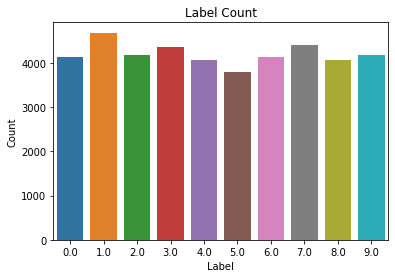

In [6]:
# Check for counts
label_count = Y_train.value_counts()
print(label_count)
g = sns.countplot(x=Y_train)
g = g.set(xlabel="Label", ylabel="Count", title="Label Count")

### 4. Normalization and transformation

In [7]:
'''
Perform grayscale normalization to 
1. Reduce illumination differences
2. Increase CNN covergence rate
'''
X_train = X_train / 255.0

In [8]:
# Split the training and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.values, 
    Y_train.values, 
    test_size=0.1, 
    random_state=42
    )

# Reshape input image
X_train = X_train.reshape((-1, 1, 28, 28))
X_train = np.squeeze(X_train, axis=1)
X_test = X_test.reshape((-1, 1, 28, 28))
X_test = np.squeeze(X_test, axis=1)

# Transform from numpy arrays to tensors
Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)

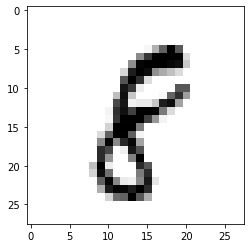

In [9]:
# Example
g = plt.imshow(X_train[0][:,:], cmap="binary")

In [10]:
# Define MNIST data class
transform_train = transforms.Compose([transforms.ToTensor()])
class MNIST(Dataset):
    def __init__(self, X, Y, Transform):
        self.X = X
        self.transform = Transform
        self.Y = Y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.transform(self.X[index]), self.Y[index]

batch_size_train, batch_size_test = 64, 1000
train_set = MNIST(X_train, Y_train, transform_train)
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

test_set = MNIST(X_test, Y_test, transform_train)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

## Convolutional Neural Network

### 1. Create CNN Model

In [11]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda


In [48]:
latent_feature = 10

class LeNet5(nn.Module):
    '''
    This implementation follow LeNet5's design from "Gradient-based learning
    applied to document recognition" by Y.Lecun with several modifications.
    
    - Two 3x3 filters replaced single 5x5 filter in conv2d layer 3
    - Batch normalization added
    - ReLU activation function replaced tanh
    - More channels added
    - Dropout added
    '''
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout2d(p=0.25),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.Dropout2d(p=0.25),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=3136, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(num_features=256),
            nn.Linear(in_features=256, out_features=latent_feature)
        )
        
    def forward(self, x):
        
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

### 2. Instantiate model, loss function, and optimizer

In [70]:
# Instantiate model and move to GPU if available
model = LeNet5()
LeNet5_classifier = model.to(device)

# Instantiate loss function
loss_fn = nn.NLLLoss()

# Instantiate optimizer
learning_rate = 0.001
optimizer = optim.Adam(LeNet5_classifier.parameters(), lr=learning_rate)

# Instantiate number of epoch, losses, score
max_epoch = 30
train_losses, test_losses = [], []
best_score = 0
best_model = None

### 3. Train and test the model

In [32]:
def train(classifier, epoch):

    classifier.train()

    for idx, (images, labels) in enumerate(train_loader):
        
        images = images.to(device, dtype=torch.float)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = classifier(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 10 == 0: # Record output every 10 batches
            train_losses.append(loss.item())
        if idx % 100 == 0: # Visualize output every 100 batches
            print(f"Epoch {epoch}: [{idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")

In [75]:
def test(classifier, epoch, best_score):
    
    classifier.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            
            images = images.to(device, dtype=torch.float)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            output = classifier(images)
            test_loss += loss_fn(output, labels).item()
            pred = output.data.max(1, keepdim=True)[1] # Get estimate of result by looking at largest class value
            correct += pred.eq(labels.data.view_as(pred)).sum()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc_val = correct/len(test_loader.dataset)
    print(f"Test result on epoch {epoch}: Avg loss is {test_loss:.6f}, Accuracy: {100.*acc_val:.6f}%", end=" ")
    if best_score <= acc_val.item():
        best_score = copy.deepcopy(acc_val.item())
        best_model = copy.deepcopy(classifier)
        print("(New Best Score)")
    else:
        print()
    return best_score

In [76]:
for epoch in range(1, max_epoch+1):
    train(LeNet5_classifier, epoch)
    best_score = test(LeNet5_classifier, epoch, best_score)

Epoch 1: [0/37800] Loss: 0.024905
Epoch 1: [6400/37800] Loss: 0.010799
Epoch 1: [12800/37800] Loss: 0.040260
Epoch 1: [19200/37800] Loss: 0.020823
Epoch 1: [25600/37800] Loss: 0.011986
Epoch 1: [32000/37800] Loss: 0.005517
Test result on epoch 1: Avg loss is 0.000033, Accuracy: 99.166664% (New Best Score)
Epoch 2: [0/37800] Loss: 0.019940
Epoch 2: [6400/37800] Loss: 0.042520
Epoch 2: [12800/37800] Loss: 0.106030
Epoch 2: [19200/37800] Loss: 0.077426
Epoch 2: [25600/37800] Loss: 0.018457
Epoch 2: [32000/37800] Loss: 0.009451
Test result on epoch 2: Avg loss is 0.000034, Accuracy: 99.166664% (New Best Score)
Epoch 3: [0/37800] Loss: 0.011831
Epoch 3: [6400/37800] Loss: 0.057239
Epoch 3: [12800/37800] Loss: 0.226552
Epoch 3: [19200/37800] Loss: 0.168799
Epoch 3: [25600/37800] Loss: 0.011063
Epoch 3: [32000/37800] Loss: 0.015229
Test result on epoch 3: Avg loss is 0.000044, Accuracy: 99.142853% 
Epoch 4: [0/37800] Loss: 0.004673
Epoch 4: [6400/37800] Loss: 0.021547
Epoch 4: [12800/37800] L